In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import shap


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA

from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

c:\ProgramData\anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FD001

In [2]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "BPR", "farB"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)

## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(20631, 27) (13096, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,0.0,0.168712,0.419699,0.281998,0.0,...,0.186883,0.364675,0.0,0.333333,0.0,0.0,0.779661,0.750000,120,-0.0_-0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.231676,0.437236,0.301955,0.0,...,0.180816,0.382647,0.0,0.301435,0.0,0.0,0.749952,0.736399,120,0.0_-0.0_100.0
2,1,3,-0.0,0.0,100.0,0.0,0.279270,0.414066,0.334500,0.0,...,0.168127,0.371184,0.0,0.227105,0.0,0.0,0.713728,0.699766,120,-0.0_0.0_100.0
3,1,4,0.0,0.0,100.0,0.0,0.295582,0.363296,0.318775,0.0,...,0.168159,0.315365,0.0,0.266806,0.0,0.0,0.671042,0.684862,120,0.0_0.0_100.0
4,1,5,-0.0,-0.0,100.0,0.0,0.305799,0.336489,0.335855,0.0,...,0.166419,0.338028,0.0,0.310184,0.0,0.0,0.664455,0.695191,120,-0.0_-0.0_100.0


In [114]:
# 1layers
def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    # model.save_weights(weights_file)

    return model

In [6]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()  # Nécessaire pour TensorFlow 1.x


In [7]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 21	13.768992	0.0	3.830708e+02	0.0	189.585159	0.0	0.10	[128]	0.2	tanh	64	30
results001 = pd.DataFrame()

for SEED in range(1):  
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 30
    epochs = 20
    nodes_per_layer = [128]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 64
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results001.to_csv('results/base/fd001.csv')

(17731, 30, 5) (17731, 1) (100, 30, 5)


NameError: name 'model_lstm_1layer' is not defined

In [8]:
results001

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,12.808482,0.0,276.375913,0.0,164.057205,0.0,[128],0.2,tanh,64,30,60.752381


In [104]:
import shap
class LSTMModelWrapper:
    def __init__(self, model, input_shape):
        """
        Wrapper for LSTM models to work with SHAP.

        Parameters:
        - model: Trained LSTM model.
        - input_shape: Tuple (timesteps, features) of the original model input shape.
        """
        self.model = model
        self.timesteps, self.features = input_shape

    def predict(self, X_flat):
        """
        Predict function for SHAP that reshapes flat input back to 3D.

        Parameters:
        - X_flat: 2D numpy array [samples, timesteps * features].

        Returns:
        - Predictions from the LSTM model.
        """
        # Reshape to 3D: [samples, timesteps, features]
        X_reshaped = X_flat.reshape(-1, self.timesteps, self.features)
        return self.model.predict(X_reshaped)

def explain_lstm_model(model, X_train, X_test, timesteps, features):
    """
    Explains an LSTM model using SHAP.

    Parameters:
    - model: Trained LSTM model.
    - X_train: Training data in 3D shape [samples, timesteps, features].
    - X_test: Test data in 3D shape [samples, timesteps, features].
    - timesteps: Number of timesteps for the LSTM model input.
    - features: Number of features for the LSTM model input.

    Returns:
    - SHAP values for the test data.
    """
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Wrap the LSTM model
    lstm_wrapper = LSTMModelWrapper(model, (timesteps, features))

    # Use SHAP KernelExplainer
    explainer = shap.KernelExplainer(lstm_wrapper.predict, X_train_flat[:20])  # Use a subset for background data
    shap_values = explainer.shap_values(X_test_flat)

    return shap_values, explainer

In [105]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:50], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


Provided model function fails when applied to the provided data set.


ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [16]:
def reshape_shap_values(shap_values, original_shape):
    """
    Reshape SHAP values to match the original input shape.

    Parameters:
        shap_values (np.ndarray): SHAP values, typically a 2D array.
        original_shape (tuple): Desired shape, typically (samples, timesteps, features).

    Returns:
        np.ndarray: Reshaped SHAP values.
    """
    # Vérifiez que le produit des dimensions correspond
    if shap_values.shape[1] != np.prod(original_shape[1:]):
        raise ValueError("SHAP values cannot be reshaped to the desired shape. Check dimensions.")
    
    # Reshape des SHAP values
    reshaped_shap = shap_values.reshape(original_shape)
    return reshaped_shap


In [17]:
# Dimensions originales
samples = 100
timesteps = 30
features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)


Shape reshaped: (100, 30, 5)


In [18]:
e1 = shap_values_reshaped[:1, :, :]
somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
print("Somme des valeurs absolues par feature :", somme_abs_par_feature)

Somme des valeurs absolues par feature : [17.68757014 16.88756651 15.27825288 14.81890962 13.97101259]


Somme des valeurs absolues par feature : [17.68757014 16.88756651 15.27825288 14.81890962 13.97101259]


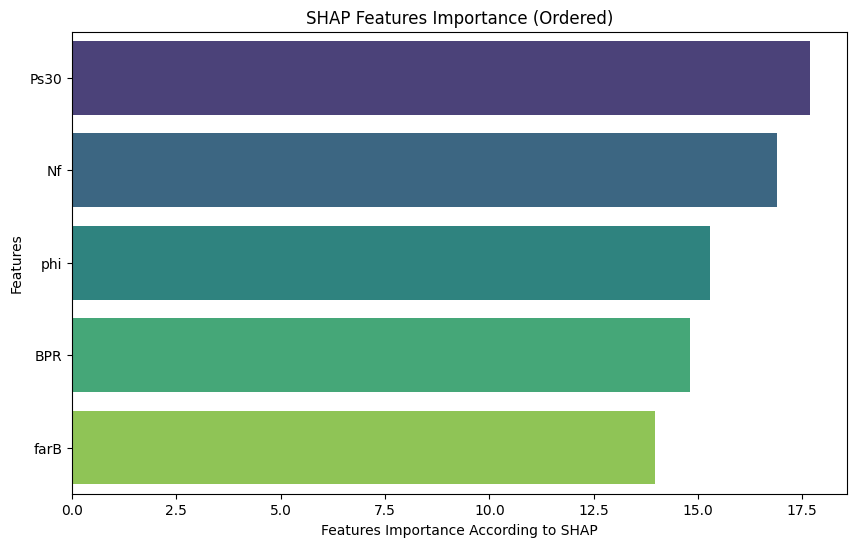

In [19]:
# Convertir les données en DataFrame pour faciliter le tri

e1 = shap_values_reshaped[:1, :, :]
somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


df_features = pd.DataFrame({
    "Feature": remaining_sensors,
    "Importance": somme_abs_par_feature
})

# Trier les données par importance décroissante
df_features = df_features.sort_values(by="Importance", ascending=False)

# Création du barplot ordonné
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=df_features,
    palette="viridis"
)
plt.xlabel("Features Importance According to SHAP")
plt.ylabel("Features")
plt.title("SHAP Features Importance (Ordered)")
plt.show()


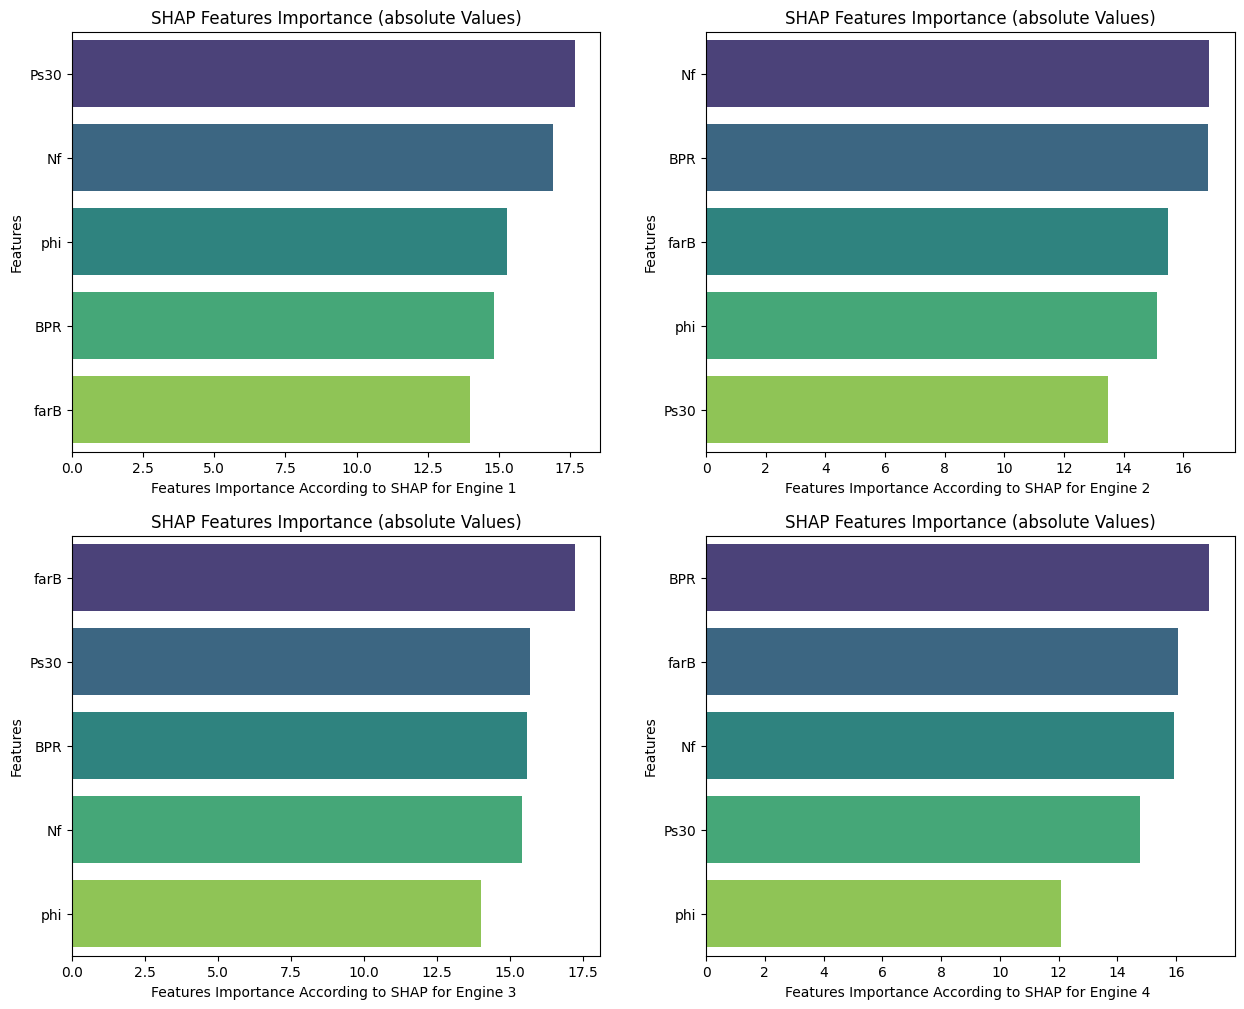

In [27]:
# Convertir les données en DataFrame pour faciliter le tri
plt.figure(figsize=(15, 12))
for i in range(4) : 
    e1 = shap_values_reshaped[i:i+1, :, :]
    somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
    # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


    df_features = pd.DataFrame({
        "Feature": remaining_sensors,
        "Importance": somme_abs_par_feature
    })

    # Trier les données par importance décroissante
    df_features = df_features.sort_values(by="Importance", ascending=False)
    plt.subplot(2,2, i+1)
    # Création du barplot ordonné
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_features,
        palette="viridis"
    )
    plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
    plt.ylabel("Features")
    plt.title("SHAP Features Importance (absolute Values)")
plt.savefig('images/shap_value001.png')
plt.show()


### FD002

In [40]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD002.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    # 'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "epr"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
# ## Data cleaning
alpha = 0.3
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(53759, 27) (33991, 26) (259, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,35.0,0.84,100.0,0.0,0.325733,0.271554,0.561254,0.0,...,0.052796,0.497413,0.0,0.400000,0.0,0.0,0.373494,0.323963,120,35.0_0.84_100.0
1,1,2,42.0,0.84,100.0,0.0,0.447218,0.357533,0.470959,0.0,...,0.095143,0.456428,0.0,0.360784,0.0,0.0,0.309302,0.391651,120,42.0_0.84_100.0
2,1,3,25.0,0.62,60.0,0.0,0.553232,0.355037,0.466030,0.0,...,0.110085,0.414226,0.0,0.470015,0.0,0.0,0.286071,0.531223,120,25.0_0.62_60.0
3,1,4,42.0,0.84,100.0,0.0,0.495285,0.387258,0.447732,0.0,...,0.107374,0.381830,0.0,0.372189,0.0,0.0,0.359184,0.632675,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.528642,0.383824,0.455578,0.0,...,0.104597,0.378322,0.0,0.454340,0.0,0.0,0.343109,0.552861,120,25.0_0.62_60.0


In [41]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 16.603718	0.0	1.343367e+03	0.0	275.683502	0.0	0.20	[32]	0.1	tanh	128	40
results002 = pd.DataFrame()

for SEED in range(1):  
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.2
    sequence_length = 40
    epochs = 50
    nodes_per_layer = [32]
    dropout = 0.1
    activation = 'tanh'
    batch_size = 128
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results002 = pd.concat([results002, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results002.to_csv('results/base/fd002.csv')

(43619, 40, 4) (43619, 1) (259, 40, 4)
Epoch 1/50
341/341 [==============================] - 3s 7ms/step - loss: 2253.5918 - val_loss: 1687.3691
Epoch 2/50
341/341 [==============================] - 2s 6ms/step - loss: 1055.4463 - val_loss: 534.1768
Epoch 3/50
341/341 [==============================] - 2s 6ms/step - loss: 387.8621 - val_loss: 434.9291
Epoch 4/50
341/341 [==============================] - 2s 6ms/step - loss: 345.2605 - val_loss: 454.3236
Epoch 5/50
341/341 [==============================] - 2s 6ms/step - loss: 331.3323 - val_loss: 447.4967
Epoch 6/50
341/341 [==============================] - 2s 6ms/step - loss: 327.9803 - val_loss: 453.5408
Epoch 7/50
341/341 [==============================] - 2s 6ms/step - loss: 319.6489 - val_loss: 412.6002
Epoch 8/50
341/341 [==============================] - 2s 6ms/step - loss: 315.8292 - val_loss: 416.5438
Epoch 9/50
341/341 [==============================] - 2s 6ms/step - loss: 306.3144 - val_loss: 406.6575
Epoch 10/50
341/341 [=

In [42]:
results002

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.489687,0.0,1047.424084,0.0,209.951035,0.0,[32],0.1,tanh,128,40,112.158437


##### Generation de shap shap values

In [43]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:50], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 16ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1480/1480 [==============================] - 3s 2ms/step


  2%|▏         | 1/50 [00:03<02:51,  3.50s/it]

1480/1480 [==============================] - 2s 2ms/step


  4%|▍         | 2/50 [00:06<02:43,  3.40s/it]

1480/1480 [==============================] - 3s 2ms/step


  6%|▌         | 3/50 [00:10<02:50,  3.62s/it]

1480/1480 [==============================] - 3s 2ms/step


  8%|▊         | 4/50 [00:14<02:53,  3.77s/it]

1480/1480 [==============================] - 3s 2ms/step


 10%|█         | 5/50 [00:18<02:55,  3.89s/it]

1480/1480 [==============================] - 3s 2ms/step


 12%|█▏        | 6/50 [00:22<02:48,  3.83s/it]

1480/1480 [==============================] - 3s 2ms/step


 14%|█▍        | 7/50 [00:26<02:45,  3.84s/it]

1480/1480 [==============================] - 3s 2ms/step


 16%|█▌        | 8/50 [00:30<02:42,  3.87s/it]

1480/1480 [==============================] - 3s 2ms/step


 18%|█▊        | 9/50 [00:34<02:36,  3.81s/it]

1480/1480 [==============================] - 3s 2ms/step


 20%|██        | 10/50 [00:37<02:32,  3.81s/it]

1480/1480 [==============================] - 3s 2ms/step


 22%|██▏       | 11/50 [00:41<02:27,  3.78s/it]

1480/1480 [==============================] - 4s 2ms/step


 24%|██▍       | 12/50 [00:45<02:30,  3.97s/it]

1480/1480 [==============================] - 3s 2ms/step


 26%|██▌       | 13/50 [00:49<02:24,  3.91s/it]

1480/1480 [==============================] - 4s 3ms/step


 28%|██▊       | 14/50 [00:54<02:28,  4.12s/it]

1480/1480 [==============================] - 2s 2ms/step


 30%|███       | 15/50 [00:57<02:17,  3.91s/it]

1480/1480 [==============================] - 3s 2ms/step


 32%|███▏      | 16/50 [01:02<02:17,  4.04s/it]

1480/1480 [==============================] - 2s 2ms/step


 34%|███▍      | 17/50 [01:05<02:06,  3.84s/it]

1480/1480 [==============================] - 3s 2ms/step


 36%|███▌      | 18/50 [01:09<02:06,  3.96s/it]

1480/1480 [==============================] - 2s 2ms/step


 38%|███▊      | 19/50 [01:13<01:57,  3.79s/it]

1480/1480 [==============================] - 3s 2ms/step


 40%|████      | 20/50 [01:17<01:58,  3.94s/it]

1480/1480 [==============================] - 2s 2ms/step


 42%|████▏     | 21/50 [01:20<01:47,  3.69s/it]

1480/1480 [==============================] - 3s 2ms/step


 44%|████▍     | 22/50 [01:24<01:47,  3.83s/it]

1480/1480 [==============================] - 2s 2ms/step


 46%|████▌     | 23/50 [01:27<01:37,  3.62s/it]

1480/1480 [==============================] - 3s 2ms/step


 48%|████▊     | 24/50 [01:31<01:33,  3.61s/it]

1480/1480 [==============================] - 4s 2ms/step


 50%|█████     | 25/50 [01:35<01:36,  3.88s/it]

1480/1480 [==============================] - 3s 2ms/step


 52%|█████▏    | 26/50 [01:40<01:35,  3.99s/it]

1480/1480 [==============================] - 3s 2ms/step


 54%|█████▍    | 27/50 [01:43<01:30,  3.92s/it]

1480/1480 [==============================] - 3s 2ms/step


 56%|█████▌    | 28/50 [01:48<01:28,  4.02s/it]

1480/1480 [==============================] - 3s 2ms/step


 58%|█████▊    | 29/50 [01:51<01:19,  3.77s/it]

1480/1480 [==============================] - 3s 2ms/step


 60%|██████    | 30/50 [01:55<01:17,  3.88s/it]

1480/1480 [==============================] - 3s 2ms/step


 62%|██████▏   | 31/50 [02:01<01:24,  4.46s/it]

1480/1480 [==============================] - 3s 2ms/step


 64%|██████▍   | 32/50 [02:05<01:17,  4.32s/it]

1480/1480 [==============================] - 3s 2ms/step


 66%|██████▌   | 33/50 [02:08<01:10,  4.13s/it]

1480/1480 [==============================] - 4s 3ms/step


 68%|██████▊   | 34/50 [02:13<01:09,  4.36s/it]

1480/1480 [==============================] - 3s 2ms/step


 70%|███████   | 35/50 [02:17<01:03,  4.21s/it]

1480/1480 [==============================] - 3s 2ms/step


 72%|███████▏  | 36/50 [02:21<00:57,  4.12s/it]

1480/1480 [==============================] - 3s 2ms/step


 74%|███████▍  | 37/50 [02:25<00:51,  3.98s/it]

1480/1480 [==============================] - 3s 2ms/step


 76%|███████▌  | 38/50 [02:29<00:48,  4.03s/it]

1480/1480 [==============================] - 3s 2ms/step


 78%|███████▊  | 39/50 [02:33<00:43,  3.96s/it]

1480/1480 [==============================] - 4s 3ms/step


 80%|████████  | 40/50 [02:38<00:42,  4.21s/it]

1480/1480 [==============================] - 3s 2ms/step


 82%|████████▏ | 41/50 [02:41<00:35,  3.98s/it]

1480/1480 [==============================] - 3s 2ms/step


 84%|████████▍ | 42/50 [02:45<00:31,  3.90s/it]

1480/1480 [==============================] - 4s 2ms/step


 86%|████████▌ | 43/50 [02:49<00:28,  4.10s/it]

1480/1480 [==============================] - 3s 2ms/step


 88%|████████▊ | 44/50 [02:53<00:24,  4.04s/it]

1480/1480 [==============================] - 3s 2ms/step


 90%|█████████ | 45/50 [02:57<00:20,  4.03s/it]

1480/1480 [==============================] - 4s 3ms/step


 92%|█████████▏| 46/50 [03:02<00:17,  4.27s/it]

1480/1480 [==============================] - 3s 2ms/step


 94%|█████████▍| 47/50 [03:06<00:12,  4.31s/it]

1480/1480 [==============================] - 3s 2ms/step


 96%|█████████▌| 48/50 [03:10<00:08,  4.12s/it]

1480/1480 [==============================] - 3s 2ms/step


 98%|█████████▊| 49/50 [03:14<00:03,  3.97s/it]

1480/1480 [==============================] - 3s 2ms/step


100%|██████████| 50/50 [03:17<00:00,  3.96s/it]


In [44]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)


Shape reshaped: (100, 40, 4)


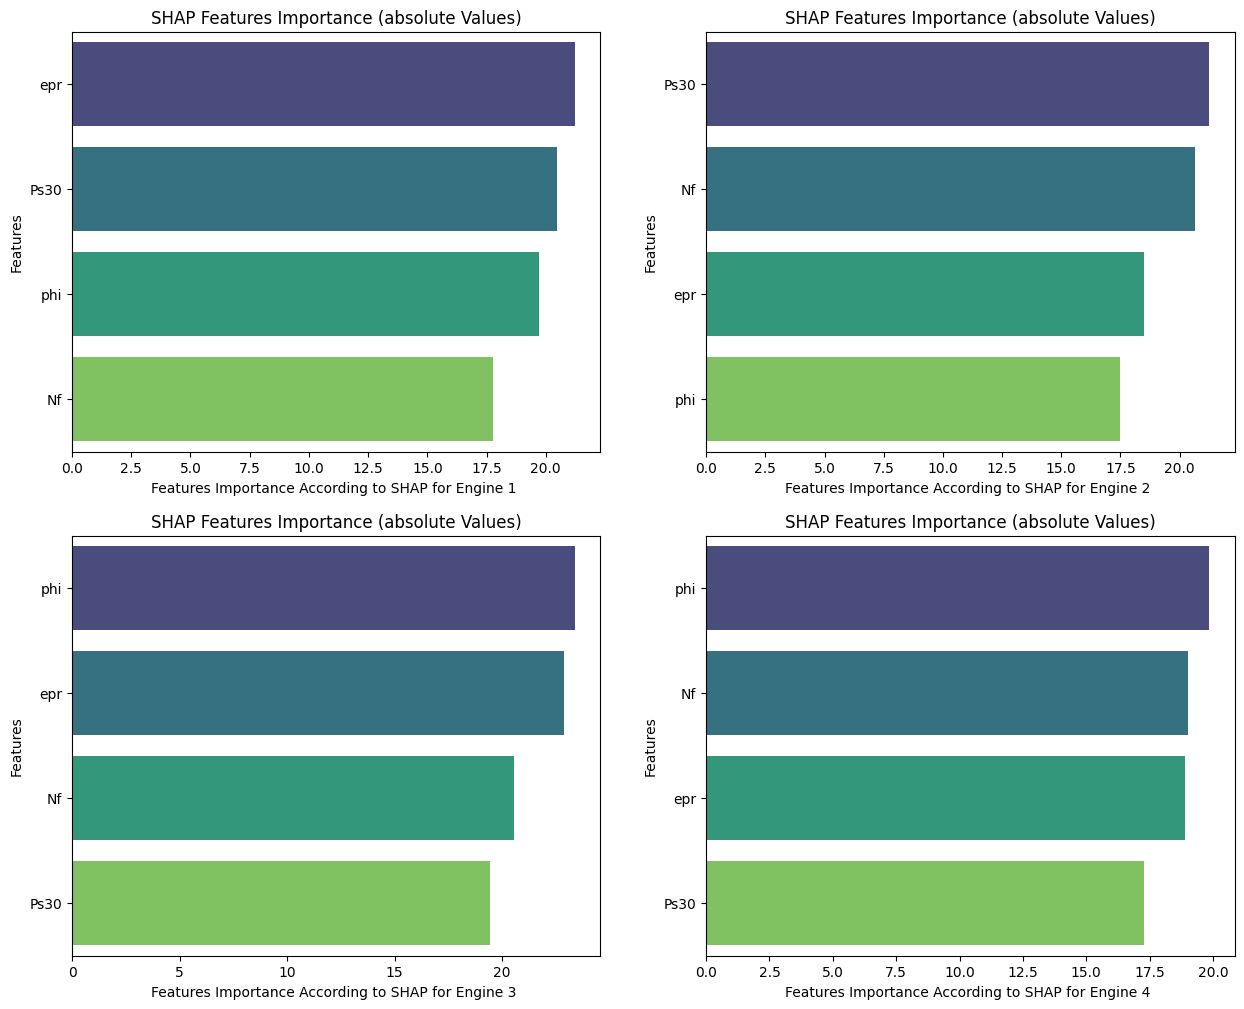

In [45]:
# Convertir les données en DataFrame pour faciliter le tri
plt.figure(figsize=(15, 12))
for i in range(4) : 
    e1 = shap_values_reshaped[i:i+1, :, :]
    somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
    # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


    df_features = pd.DataFrame({
        "Feature": remaining_sensors,
        "Importance": somme_abs_par_feature
    })

    # Trier les données par importance décroissante
    df_features = df_features.sort_values(by="Importance", ascending=False)
    plt.subplot(2,2, i+1)
    # Création du barplot ordonné
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_features,
        palette="viridis"
    )
    plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
    plt.ylabel("Features")
    plt.title("SHAP Features Importance (absolute Values)")
plt.savefig('images/shap_value002.png')
plt.show()


#### FD003

In [47]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors = ["Ps30", "NRc", "W31", "BPR"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 125
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(24720, 27) (16596, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,0.0,100.0,0.0,0.378788,0.341211,0.279748,0.0,...,0.238238,0.618635,0.0,0.272727,0.0,0.0,0.546584,0.469595,125,-0.0_0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.403623,0.371855,0.295333,0.0,...,0.270487,0.639660,0.0,0.320574,0.0,0.0,0.515568,0.505576,125,0.0_-0.0_100.0
2,1,3,-0.0,-0.0,100.0,0.0,0.376607,0.365007,0.349504,0.0,...,0.273559,0.596319,0.0,0.302918,0.0,0.0,0.478323,0.472777,125,-0.0_-0.0_100.0
3,1,4,-0.0,0.0,100.0,0.0,0.426586,0.372434,0.306566,0.0,...,0.265180,0.574722,0.0,0.320574,0.0,0.0,0.471081,0.455219,125,-0.0_0.0_100.0
4,1,5,0.0,0.0,100.0,0.0,0.370454,0.395376,0.307426,0.0,...,0.268241,0.570330,0.0,0.331090,0.0,0.0,0.495162,0.473204,125,0.0_0.0_100.0


In [51]:
%%time

# 	RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 43	15.404917	0.0	8.255290e+02	0.0	237.311462	0.0	0.10	[64]	0.2	tanh	32	35
results003 = pd.DataFrame()

for SEED in range(1):
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 35
    epochs = 40
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results003 = pd.concat([results003, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results003.to_csv('results/base/fd003.csv')

(21320, 35, 4) (21320, 1) (100, 35, 4)
Epoch 1/40
667/667 [==============================] - 4s 5ms/step - loss: 1964.9844 - val_loss: 1052.8940
Epoch 2/40
667/667 [==============================] - 3s 5ms/step - loss: 502.5666 - val_loss: 492.7460
Epoch 3/40
667/667 [==============================] - 3s 5ms/step - loss: 435.9413 - val_loss: 480.9764
Epoch 4/40
667/667 [==============================] - 3s 5ms/step - loss: 386.0496 - val_loss: 471.1716
Epoch 5/40
667/667 [==============================] - 4s 5ms/step - loss: 335.3236 - val_loss: 453.4883
Epoch 6/40
667/667 [==============================] - 4s 5ms/step - loss: 317.4990 - val_loss: 350.0948
Epoch 7/40
667/667 [==============================] - 4s 5ms/step - loss: 305.8929 - val_loss: 431.5654
Epoch 8/40
667/667 [==============================] - 3s 5ms/step - loss: 296.5133 - val_loss: 292.7155
Epoch 9/40
667/667 [==============================] - 3s 5ms/step - loss: 285.0289 - val_loss: 343.9412
Epoch 10/40
667/667 [==

In [52]:
results003

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.841196,0.0,951.060535,0.0,220.261093,0.0,[64],0.2,tanh,32,35,144.378017


### Shap explanation Generation

In [53]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:50], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


1/1 [==============================] - 0s 22ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1455/1455 [==============================] - 3s 2ms/step


  2%|▏         | 1/50 [00:03<02:59,  3.67s/it]

1455/1455 [==============================] - 3s 2ms/step


  4%|▍         | 2/50 [00:07<03:03,  3.83s/it]

1455/1455 [==============================] - 3s 2ms/step


  6%|▌         | 3/50 [00:11<03:09,  4.03s/it]

1455/1455 [==============================] - 3s 2ms/step


  8%|▊         | 4/50 [00:15<03:03,  3.98s/it]

1455/1455 [==============================] - 3s 2ms/step


 10%|█         | 5/50 [00:20<03:03,  4.07s/it]

1455/1455 [==============================] - 3s 2ms/step


 12%|█▏        | 6/50 [00:24<03:01,  4.11s/it]

1455/1455 [==============================] - 3s 2ms/step


 14%|█▍        | 7/50 [00:28<02:57,  4.13s/it]

1455/1455 [==============================] - 3s 2ms/step


 16%|█▌        | 8/50 [00:32<02:50,  4.07s/it]

1455/1455 [==============================] - 4s 3ms/step


 18%|█▊        | 9/50 [00:36<02:54,  4.26s/it]

1455/1455 [==============================] - 4s 3ms/step


 20%|██        | 10/50 [00:41<02:58,  4.46s/it]

1455/1455 [==============================] - 4s 3ms/step


 22%|██▏       | 11/50 [00:47<03:10,  4.90s/it]

1455/1455 [==============================] - 3s 2ms/step


 24%|██▍       | 12/50 [00:51<02:52,  4.53s/it]

1455/1455 [==============================] - 4s 3ms/step


 26%|██▌       | 13/50 [00:56<02:50,  4.61s/it]

1455/1455 [==============================] - 3s 2ms/step


 28%|██▊       | 14/50 [01:00<02:36,  4.35s/it]

1455/1455 [==============================] - 4s 3ms/step


 30%|███       | 15/50 [01:04<02:37,  4.51s/it]

1455/1455 [==============================] - 4s 3ms/step


 32%|███▏      | 16/50 [01:09<02:34,  4.54s/it]

1455/1455 [==============================] - 3s 2ms/step


 34%|███▍      | 17/50 [01:13<02:25,  4.41s/it]

1455/1455 [==============================] - 3s 2ms/step


 36%|███▌      | 18/50 [01:17<02:19,  4.37s/it]

1455/1455 [==============================] - 3s 2ms/step


 38%|███▊      | 19/50 [01:21<02:11,  4.23s/it]

1455/1455 [==============================] - 4s 3ms/step


 40%|████      | 20/50 [01:26<02:10,  4.35s/it]

1455/1455 [==============================] - 3s 2ms/step


 42%|████▏     | 21/50 [01:30<02:04,  4.30s/it]

1455/1455 [==============================] - 3s 2ms/step


 44%|████▍     | 22/50 [01:35<02:02,  4.37s/it]

1455/1455 [==============================] - 3s 2ms/step


 46%|████▌     | 23/50 [01:39<01:56,  4.31s/it]

1455/1455 [==============================] - 3s 2ms/step


 48%|████▊     | 24/50 [01:43<01:52,  4.32s/it]

1455/1455 [==============================] - 4s 3ms/step


 50%|█████     | 25/50 [01:48<01:49,  4.37s/it]

1455/1455 [==============================] - 3s 2ms/step


 52%|█████▏    | 26/50 [01:52<01:43,  4.33s/it]

1455/1455 [==============================] - 3s 2ms/step


 54%|█████▍    | 27/50 [01:56<01:38,  4.28s/it]

1455/1455 [==============================] - 3s 2ms/step


 56%|█████▌    | 28/50 [02:00<01:32,  4.22s/it]

1455/1455 [==============================] - 3s 2ms/step


 58%|█████▊    | 29/50 [02:04<01:29,  4.24s/it]

1455/1455 [==============================] - 3s 2ms/step


 60%|██████    | 30/50 [02:09<01:24,  4.20s/it]

1455/1455 [==============================] - 3s 2ms/step


 62%|██████▏   | 31/50 [02:13<01:19,  4.20s/it]

1455/1455 [==============================] - 3s 2ms/step


 64%|██████▍   | 32/50 [02:17<01:15,  4.18s/it]

1455/1455 [==============================] - 3s 2ms/step


 66%|██████▌   | 33/50 [02:21<01:09,  4.06s/it]

1455/1455 [==============================] - 3s 2ms/step


 68%|██████▊   | 34/50 [02:25<01:05,  4.12s/it]

1455/1455 [==============================] - 3s 2ms/step


 70%|███████   | 35/50 [02:29<01:00,  4.04s/it]

1455/1455 [==============================] - 3s 2ms/step


 72%|███████▏  | 36/50 [02:33<00:56,  4.01s/it]

1455/1455 [==============================] - 3s 2ms/step


 74%|███████▍  | 37/50 [02:37<00:52,  4.03s/it]

1455/1455 [==============================] - 3s 2ms/step


 76%|███████▌  | 38/50 [02:41<00:49,  4.10s/it]

1455/1455 [==============================] - 4s 3ms/step


 78%|███████▊  | 39/50 [02:46<00:48,  4.40s/it]

1455/1455 [==============================] - 3s 2ms/step


 80%|████████  | 40/50 [02:51<00:44,  4.43s/it]

1455/1455 [==============================] - 3s 2ms/step


 82%|████████▏ | 41/50 [02:55<00:39,  4.35s/it]

1455/1455 [==============================] - 3s 2ms/step


 84%|████████▍ | 42/50 [02:59<00:34,  4.27s/it]

1455/1455 [==============================] - 4s 2ms/step


 86%|████████▌ | 43/50 [03:03<00:30,  4.36s/it]

1455/1455 [==============================] - 3s 2ms/step


 88%|████████▊ | 44/50 [03:08<00:25,  4.29s/it]

1455/1455 [==============================] - 4s 2ms/step


 90%|█████████ | 45/50 [03:12<00:21,  4.33s/it]

1455/1455 [==============================] - 3s 2ms/step


 92%|█████████▏| 46/50 [03:15<00:16,  4.08s/it]

1455/1455 [==============================] - 3s 2ms/step


 94%|█████████▍| 47/50 [03:19<00:12,  4.06s/it]

1455/1455 [==============================] - 3s 2ms/step


 96%|█████████▌| 48/50 [03:23<00:07,  3.96s/it]

1455/1455 [==============================] - 3s 2ms/step


 98%|█████████▊| 49/50 [03:27<00:03,  3.88s/it]

1455/1455 [==============================] - 3s 2ms/step


100%|██████████| 50/50 [03:31<00:00,  4.23s/it]


In [54]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)


Shape reshaped: (100, 35, 4)


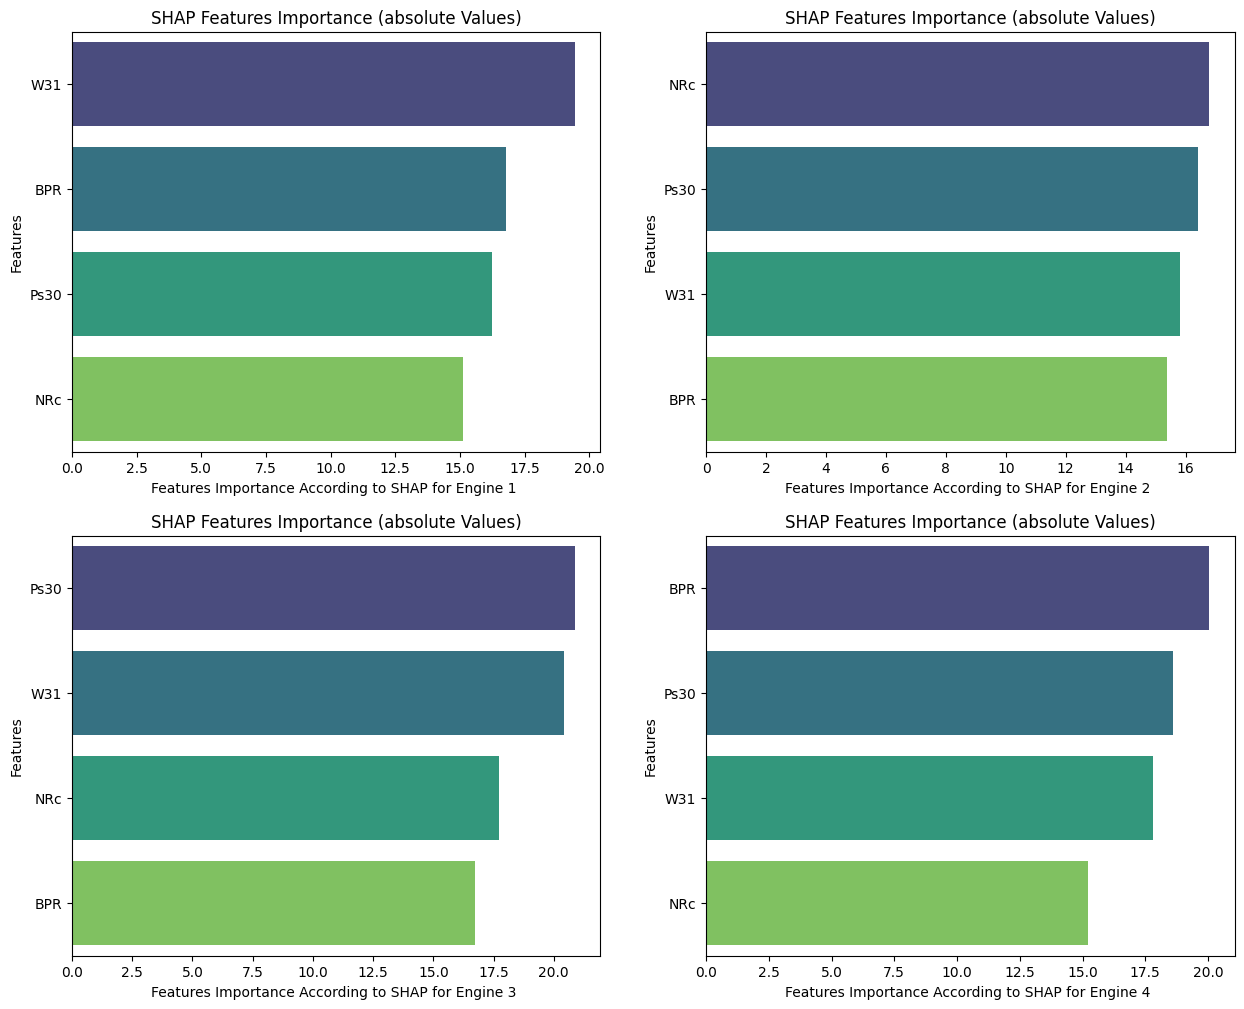

In [55]:
# Convertir les données en DataFrame pour faciliter le tri
plt.figure(figsize=(15, 12))
for i in range(4) : 
    e1 = shap_values_reshaped[i:i+1, :, :]
    somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
    # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


    df_features = pd.DataFrame({
        "Feature": remaining_sensors,
        "Importance": somme_abs_par_feature
    })

    # Trier les données par importance décroissante
    df_features = df_features.sort_values(by="Importance", ascending=False)
    plt.subplot(2,2, i+1)
    # Création du barplot ordonné
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_features,
        palette="viridis"
    )
    plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
    plt.ylabel("Features")
    plt.title("SHAP Features Importance (absolute Values)")
plt.savefig('images/shap_value003.png')
plt.show()


### FD004

In [106]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "BPR", "farB"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(61249, 27) (41214, 26) (248, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,42.0,0.84,100.0,0.0,0.500000,0.255293,0.278866,0.0,...,0.175935,0.602638,0.0,0.363636,0.0,0.0,0.460000,0.473138,120,42.0_0.84_100.0
1,1,2,20.0,0.70,100.0,0.0,0.296544,0.297306,0.246618,0.0,...,0.144143,0.589484,0.0,0.220096,0.0,0.0,0.374584,0.424327,120,20.0_0.7_100.0
2,1,3,42.0,0.84,100.0,0.0,0.293314,0.279496,0.284639,0.0,...,0.137238,0.645445,0.0,0.239517,0.0,0.0,0.354442,0.475873,120,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,0.0,0.270575,0.259617,0.308441,0.0,...,0.150673,0.635035,0.0,0.222739,0.0,0.0,0.361874,0.499703,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.258382,0.274522,0.277455,0.0,...,0.155717,0.603815,0.0,0.249746,0.0,0.0,0.327772,0.530466,120,25.0_0.62_60.0


In [107]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	nodes	dropout	activation	batch_size	TW
# 1	15.449126	0.0	1.242658e+03	0.0	238.675491	0.0	[64]	0.2	tanh	32	40
# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 2	16.100150	0.0	1.752538e+03	0.0	259.214813	0.0	0.30	[64]	0.2	tanh	32	40
results = pd.DataFrame()

for SEED in range(1):  
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.3
    sequence_length = 40
    epochs = 5
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
            
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results.to_csv('results/base/fd004.csv')

NotImplementedError: numpy() is only available when eager execution is enabled.

In [63]:
results

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.783825,0.0,1013.40173,0.0,218.561462,0.0,[64],0.2,tanh,32,40,577.368608


array([[[  2.0417122 ],
        [  1.36468015],
        [  0.75335619],
        ...,
        [-12.12116876],
        [  1.12559274],
        [  0.42678493]],

       [[  5.85682762],
        [  0.        ],
        [  0.        ],
        ...,
        [ -1.38136014],
        [ -1.72382381],
        [  0.62970885]],

       [[  0.06763312],
        [  0.0384426 ],
        [  0.60044554],
        ...,
        [ -2.98874224],
        [  1.41438955],
        [ -0.32739752]],

       ...,

       [[  2.42351005],
        [  1.18220904],
        [  4.57381505],
        ...,
        [ -8.57199166],
        [  2.17353983],
        [ -0.58661169]],

       [[  4.96472957],
        [ -0.19258314],
        [  3.14001613],
        ...,
        [-16.29897372],
        [ -1.08522991],
        [ -3.39454523]],

       [[  0.21081094],
        [  1.48739567],
        [  1.80221279],
        ...,
        [ -5.4236551 ],
        [  1.02224066],
        [ -0.56415963]]])

In [100]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:50], test_array[:50], timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array[0:5].reshape(test_array.shape[0], -1))


Provided model function fails when applied to the provided data set.


ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [65]:
# Dimensions originales
samples = 100
# timesteps = 30
# features = 5

# SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
shap_values_flat = np.random.rand(samples, timesteps * features)

# Dimensions originales des données
original_shape = (samples, timesteps, features)

# Reshape des SHAP values
shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)


Shape reshaped: (100, 40, 5)


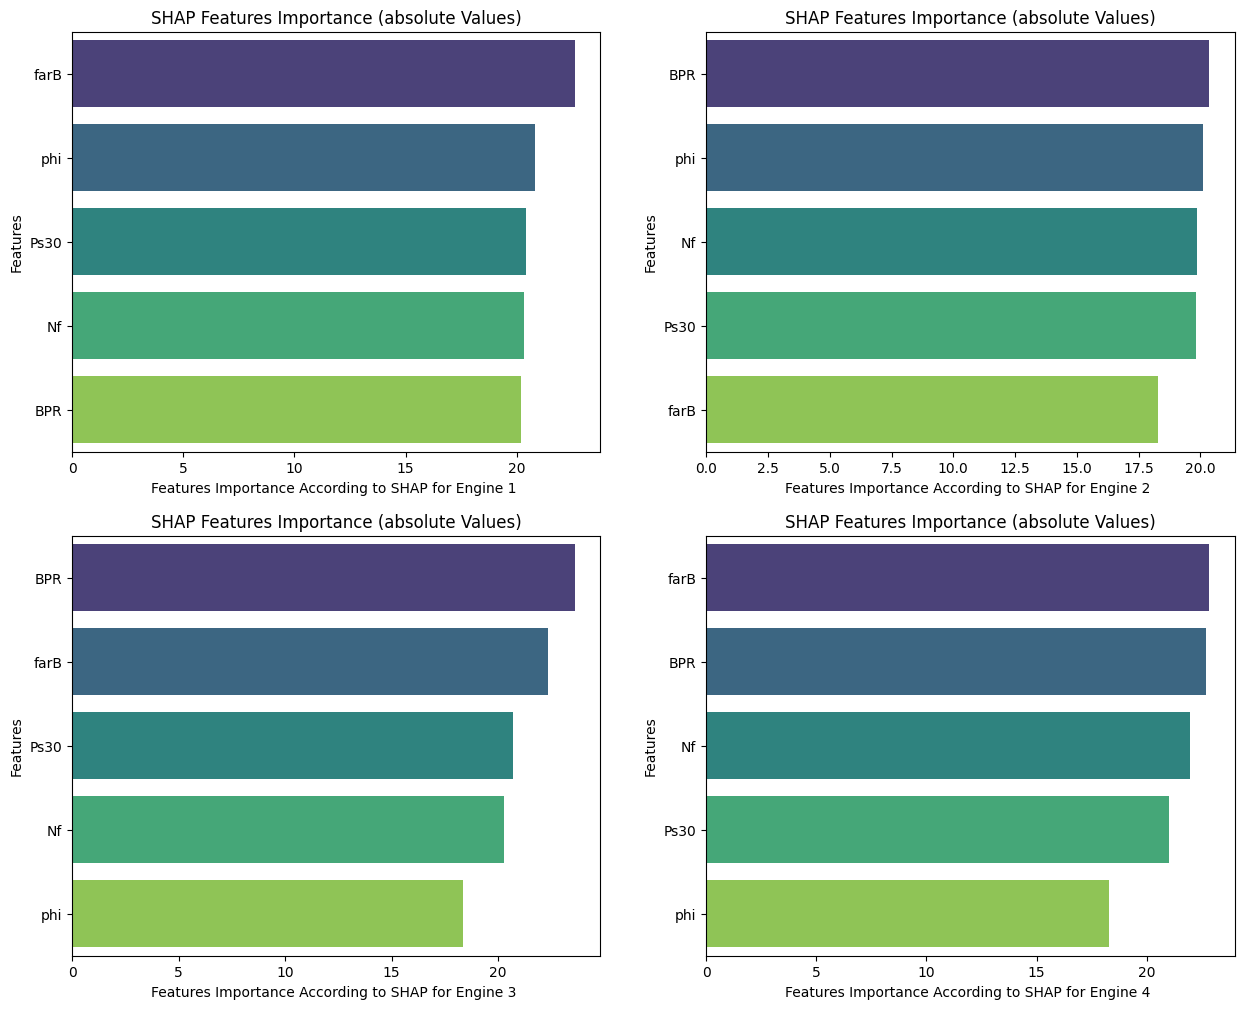

In [66]:
# Convertir les données en DataFrame pour faciliter le tri
plt.figure(figsize=(15, 12))
for i in range(4) : 
    e1 = shap_values_reshaped[i:i+1, :, :]
    somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
    # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


    df_features = pd.DataFrame({
        "Feature": remaining_sensors,
        "Importance": somme_abs_par_feature
    })

    # Trier les données par importance décroissante
    df_features = df_features.sort_values(by="Importance", ascending=False)
    plt.subplot(2,2, i+1)
    # Création du barplot ordonné
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_features,
        palette="viridis"
    )
    plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
    plt.ylabel("Features")
    plt.title("SHAP Features Importance (absolute Values)")
plt.savefig('images/shap_value004.png')
plt.show()


In [87]:
feautures_length = ['f' + str(i) for i in range(1000)]

In [86]:
shap_values.shape

(50, 200, 1)

In [89]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0])

In [91]:
shap_values_2D = shap_values[0].reshape(-1,5)
X_test_2D = test_array.reshape(-1,5)


shap_values_2D.shape,X_test_2D.shape

((40, 5), (9920, 5))

In [92]:
x_test_2d = pd.DataFrame(data=X_test_2D, columns = remaining_sensors)

AssertionError: Feature and SHAP matrices must have the same number of rows!

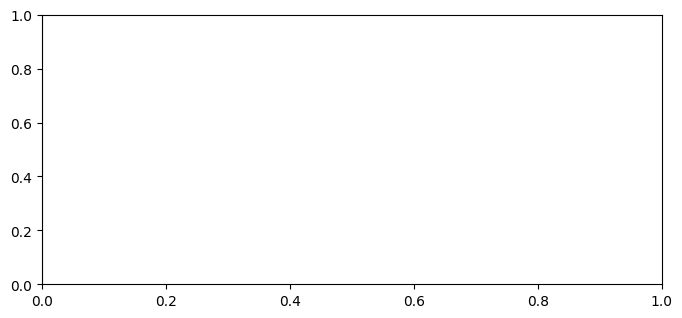

In [93]:
shap.summary_plot(shap_values_2D, x_test_2d)